# Ideas

More options:

- Pay as much as the second highest bidder?
- Different way of doing locations
- Base prices can change based on market data
- Real data
- Interest rate can change per month
- Variabele inflatie

More visualizations:

- Dates on x-axis instead of month number
- Average time to sell a house.
- Proportion of homeless people.
- Total transaction volume per step.
- Buyers, houses and sales not cummulative

## Imports

In [1]:
import mesa
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

## Data Loading

In [2]:
# data from https://fred.stlouisfed.org/series/REAINTRATREARAT10Y#0
# the data is the interest rate per month for all 120 months starting from 2013 till the end of 2023

df_interest = pd.read_csv('data_interest_rate.csv')
df_interest.drop([df_interest.index[120]], inplace=True)
df_interest.rename(columns={'Index': 'date'}, inplace=True)
display(df_interest.head())

df_inflation = pd.read_csv('inflation_data.csv')
df_inflation.drop([df_inflation.index[120]], inplace=True)
df_inflation.rename(columns={'observation_date': 'date',
                             'T10YIE': 'inflation_rate'}, inplace=True)
display(df_inflation.head())

#controle data
df_controle = pd.read_csv("AVG_house_price.csv")
df_controle.rename(columns={'observation_date': 'date',
                             'ASPUS': 'Mean Sales Price'}, inplace=True)
display(df_controle.head())

,date,interest_rate
0,01/01/2013,0.084401
1,01/02/2013,0.172100
2,01/03/2013,0.050341
3,01/04/2013,-0.024212
4,01/05/2013,-0.019391


,date,inflation_rate
0,01/01/2013,2.52
1,01/02/2013,2.55
2,01/03/2013,2.54
3,01/04/2013,2.41
4,01/05/2013,2.28


,date,Mean Sales Price
0,2013-01-01,307400
1,2013-04-01,320400
2,2013-07-01,324400
3,2013-10-01,334400
4,2014-01-01,331400


In [3]:
#Global variables
INFLATION = [inf / 12 for inf in df_inflation['inflation_rate'] for _ in range(12)]
INTEREST_RATE = df_interest["interest_rate"]
CONTROLE = df_controle["Mean Sales Price"]

#Location data
#probabilities are based on data from https://worldpopulationreview.com/states
west = ["CA", "OR", "WA", "NV", "ID", "UT", "CO", "WY", "MT"]
west_prob = [11.57 / 100, 1.26 / 100, 2.33 / 100, 0.96 / 100, 0.59 / 100, 1.03 / 100, 1.76 / 100, 0.17 / 100, 0.34 / 100]
midwest = ["ND", "SD", "NE", "KS", "MN", "IA", "MO", "WI", "IL", "IN", "MI", "OH"]
midwest_prob = [0.23 / 100, 0.28 / 100, 0.59 / 100, 0.88 / 100, 1.72 / 100, 0.96 / 100, 1.85 / 100, 1.77 / 100, 3.73 / 100, 2.05 / 100, 2.99 / 100, 3.52 / 100]
southwest = ["AZ", "NM", "TX", "OK"]
southwest_prob = [2.23 / 100, 0.63 / 100, 9.22 / 100, 1.22 / 100]
southeast = ["AR", "LA", "MS", "TN", "AL", "KY", "GA", "WV", "VA", "NC", "SC", "FL", "MD", "DE"]
southeast_prob = [0.92 / 100, 1.36 / 100, 0.88 / 100, 2.14 / 100, 1.53 / 100, 1.35 / 100, 3.32 / 100, 0.53 / 100, 2.61 / 100, 3.27 / 100, 1.63 / 100, 6.83 / 100, 1.83 / 100, 0.31 / 100]
northeast = ["CT", "ME", "MA", "NH", "NJ", "NY", "PA", "RI", "VT"]
northeast_prob = [1.08 / 100, 0.42 / 100, 2.09 / 100, 0.42 / 100, 2.78 / 100, 5.8 / 100, 3.86 / 100, 0.33 / 100, 0.19 / 100]
hawai_group = ["HI"]
hawai_group_prob = [0.42 / 100]
alaska_group =["AK"]
alaska_group_prob = [0.22 / 100]

#Global variables for location
USA_LOCATIONS = [southeast, west, midwest, southwest, northeast, hawai_group, alaska_group]
USA_LOCATION_GENERATE = southeast + west + midwest + southwest + northeast + hawai_group + alaska_group #locations for generating
USA_LOCATIONS_PROB = southeast_prob + west_prob + midwest_prob + southwest_prob + northeast_prob + hawai_group_prob + alaska_group_prob

In [4]:
# based on information from https://www.home-cost.com/cost-per-sf-by-state/
AVERAGE_COST_PER_SF = {
    'AL': 115, 'AK': 225, 'AZ': 155,
    'AR': 120, 'CA': 300, 'CO': 200,
    'CT': 215, 'DE': 145, 'FL': 155,
    'GA': 140, 'HI': 450, 'ID': 150,
    'IL': 160, 'IN': 130, 'IA': 130,
    'KS': 130, 'KY': 120, 'LA': 120,
    'ME': 200, 'MD': 160, 'MA': 275,
    'MI': 140, 'MN': 200, 'MS': 115,
    'MO': 130, 'MT': 200, 'NE': 130,
    'NV': 190, 'NH': 200, 'NJ': 240,
    'NM': 140, 'NY': 275, 'NC': 140,
    'ND': 130, 'OH': 130, 'OK': 115,
    'OR': 200, 'PA': 160, 'RI': 215,
    'SC': 140, 'SD': 130, 'TN': 155,
    'TX': 150, 'UT': 155, 'VT': 200,
    'VA': 160, 'WA': 200, 'WV': 120,
    'WI': 160, 'WY': 200
}

REGION_DICT = {}
for region_states in USA_LOCATIONS:
    for state in region_states:
        REGION_DICT[state] = region_states
REGION_DICT

{'AR': ['AR',
  'LA',
  'MS',
  'TN',
  'AL',
  'KY',
  'GA',
  'WV',
  'VA',
  'NC',
  'SC',
  'FL',
  'MD',
  'DE'],
 'LA': ['AR',
  'LA',
  'MS',
  'TN',
  'AL',
  'KY',
  'GA',
  'WV',
  'VA',
  'NC',
  'SC',
  'FL',
  'MD',
  'DE'],
 'MS': ['AR',
  'LA',
  'MS',
  'TN',
  'AL',
  'KY',
  'GA',
  'WV',
  'VA',
  'NC',
  'SC',
  'FL',
  'MD',
  'DE'],
 'TN': ['AR',
  'LA',
  'MS',
  'TN',
  'AL',
  'KY',
  'GA',
  'WV',
  'VA',
  'NC',
  'SC',
  'FL',
  'MD',
  'DE'],
 'AL': ['AR',
  'LA',
  'MS',
  'TN',
  'AL',
  'KY',
  'GA',
  'WV',
  'VA',
  'NC',
  'SC',
  'FL',
  'MD',
  'DE'],
 'KY': ['AR',
  'LA',
  'MS',
  'TN',
  'AL',
  'KY',
  'GA',
  'WV',
  'VA',
  'NC',
  'SC',
  'FL',
  'MD',
  'DE'],
 'GA': ['AR',
  'LA',
  'MS',
  'TN',
  'AL',
  'KY',
  'GA',
  'WV',
  'VA',
  'NC',
  'SC',
  'FL',
  'MD',
  'DE'],
 'WV': ['AR',
  'LA',
  'MS',
  'TN',
  'AL',
  'KY',
  'GA',
  'WV',
  'VA',
  'NC',
  'SC',
  'FL',
  'MD',
  'DE'],
 'VA': ['AR',
  'LA',
  'MS',
  'TN',
  'AL',
  

## help functions

In [5]:
def location_pref(location_person, location_building):
    """Gives 1 back if location is the same, 2 if location is nearby and 3 if none of the two before"""
    temp_var = None
    if location_person == location_building:
        return 1
    else:
        for i in range(len(USA_LOCATIONS)):
            if location_person in USA_LOCATIONS[i]:
                temp_var = i
                break
    if temp_var != None and location_building in USA_LOCATIONS[temp_var]:
        return 2
    return 3
    
def results_to_per_querter(results):
    ds_results = []
    sum_var = 0
    for i in range(len(results)):
        sum_var += results[i]
        if (i + 1) % 3 == 0:
            ds_results.append(sum_var / 3)
            sum_var = 0
    return ds_results


## Classes

In [6]:
class Buyer(mesa.Agent):
    def __init__(self, model, salary: float, savings: float, age: float, dual_income: bool, preferred_location: str):
        super().__init__(model)
        self.salary = salary * 1.5 if dual_income else salary # assume dual_income increases salary by 50%
        self.savings = savings
        self.age = age
        self.dual_income = dual_income
        self.preferred_location = preferred_location
        self.budget = self.calculate_budget(model)
        prob_not_bought_before = min(1, self.age / 40)
        self.bought_before = np.random.choice([True, False], p = [prob_not_bought_before, 1 - prob_not_bought_before])
        
    def calculate_budget(self, model):
        mean_willing_to_pay_percentage = 1
        std_willing_to_pay_percentage = 0.1
        multiplier = np.random.normal(mean_willing_to_pay_percentage, std_willing_to_pay_percentage)
        # use age as a indicator of how much willing to pay and add some randomness
        willing_to_pay_percentage = (0.3 - (0.10 * (self.age - 20) / 40)) * multiplier
        
        payments = 360 # assume a 30 year morgage: 12 months * 30 years = 360
    
        down_payment_percentage = 0.20  # Assume 20% down payment
        down_payment = self.savings * down_payment_percentage

        max_monthly_payment = self.salary / 12 * willing_to_pay_percentage
        loan_amount = (max_monthly_payment * ((1 + model.interest_rate_monthly)**payments - 1)) / \
                      (model.interest_rate_monthly * (1 + model.interest_rate_monthly)**payments)
        
        # Total budget is the loan amount plus the down payment
        total_budget = loan_amount + down_payment
        
        return total_budget

class House(mesa.Agent):
    def __init__(self, model, location: str, size: int):
        super().__init__(model)
        self.location = location
        self.size = size
        self.market_price = self.calculate_market_price()
    
    def calculate_market_price(self):
        # Base price per foot unit (adjust based on location)
        base_price_per_sf = AVERAGE_COST_PER_SF[self.location]
    
        # Calculate the total price based on size
        price = base_price_per_sf * self.size
        return price

class Market(mesa.Model):
    def __init__(self, num_buyers, num_houses):
        super().__init__()
        self.buyers = []
        self.houses = []
        self.sales = []
        self.time = 0
        self.buyer_counts = []
        self.house_counts = []
        self.sale_counts = []
        self.average_prices = []
        self.price_conf_intervals = []

        self.interest_rate_monthly = INTEREST_RATE[0] / 100 / 12
        self.inflation_total = 1

        # Create initial buyers
        for _ in range(num_buyers):
            self.add_buyer()

        # Create initial houses
        for _ in range(num_houses):
            self.add_house()

    def add_buyer(self):
        savings = random.uniform(0, 100_000) # add realistic savings
        kill_agents = []
        # age data found at https://datacenter.aecf.org/data/tables/6538-adult-population-by-age-group#detailed/1/any/false/36/117,2801,2802,2803/13515,13516
        # education data found at https://nces.ed.gov/programs/coe/indicator/cba/annual-earnings and https://www.census.gov/newsroom/press-releases/2022/educational-attainment.html 
        # NOTE: The salary of males and females are combined into an average
        age_group = random.choices(['18-24','25-64','65+'], weights=[0.13, 0.69, 0.18], k=1)[0]
        edu_group = random.choices(['hs', 'ass', 'bac'], weights=[45, 17, 38], k=1)[0]
        if age_group == '18-24':
                age = random.randint(18, 24)
        elif age_group == '25-64':
                age = random.randint(25, 64)
        else:
                age = random.randint(65, 80)
        # death rates by age data found at: https://www.cdc.gov/nchs/products/databriefs/db492.htm
        if age in range(18, 24): 
            death_rate = 80/100000

        elif age in range(25, 34):
            death_rate = 163.4/100000

        elif age in range(35, 44):
            death_rate = 255.4/100000
            
        elif age in range(45, 54): 
            death_rate = 453.3/100000
        
        elif age in range(55, 64):
            death_rate = 992.1/100000
        
        elif age in range(65, 74):
            death_rate = 1978.7/100000
        
        elif age in range(75, 84):
            death_rate = 4708.2/100000
        
        else:
            death_rate = 14389.6/100000

        # pension calculation found at https://equable.org/pension-basics-how-pension-benefits-are-calculated/
        # average age for a degree found at https://learn.org/articles/normal_age_finish_college.html
        if age_group != '65+':
                if edu_group == 'hs':
                    mean_salary = 42100 * self.inflation_total
                elif edu_group == 'ass':
                    mean_salary = 50600 * self.inflation_total
                else:
                    mean_salary = 68500 * self.inflation_total
        else:
                if edu_group == 'hs':
                    mean_salary = (random.randint(59, 65) - random.randint(17, 18)) * 0.02 * 42100 * self.inflation_total
                elif edu_group == 'ass':
                    mean_salary = (random.randint(59, 65) - random.randint(23, 29)) * 0.02 * 50600 * self.inflation_total
                else:
                    mean_salary = (random.randint(59, 65) - random.randint(23, 29)) * 0.02 * 68500 * self.inflation_total
        
        dual_income = random.random() < 0.3  # 30% dual income households
        preferred_location = np.random.choice(USA_LOCATION_GENERATE, p = USA_LOCATIONS_PROB)
        buyer = Buyer(self, mean_salary, savings, age, dual_income, preferred_location)
        self.buyers.append(buyer)
        self.agents.add(buyer)
        print(age, mean_salary)
        if random.random() < death_rate:
            print(f"Buyer aged {age} has died.")
            self.buyers.remove(buyer)
            self.agents.remove(buyer)

    def add_house(self):
        location = np.random.choice(USA_LOCATION_GENERATE, p = USA_LOCATIONS_PROB)
        
        mean_size = 3
        std_dev_size = 1
        size = int(np.clip(np.random.normal(mean_size, std_dev_size), 0.5, 10))
        
        house = House(self, location, size)
        self.houses.append(house)
        self.agents.add(house)
    
    def step(self, inflation_step, interest_rate_step):
        # each time step is one month
        
        self.inflation_step = 1 + inflation_step
        self.inflation_total *= (1 + inflation_step)
        self.interest_rate_monthly = interest_rate_step / 100 / 12
        self.time += 1
        
        if self.time >= 90:
            for _ in range(random.randint(0, int(NUM_BUYERS * 0.07 / 2))): self.add_buyer() # add realistic chances
            for _ in range (random.randint(0, int(NUM_HOUSES * 0.07))): self.add_house() # add realistic chances
        else:
            for _ in range(random.randint(0, int(NUM_BUYERS * 0.07))): self.add_buyer() # add realistic chances
            for _ in range (random.randint(0, int(NUM_HOUSES * 0.07))): self.add_house() # add realistic chances


        self.agents.shuffle_do('step')

        # Salaries increase slightly
        for buyer in self.buyers:
            buyer.salary *= self.inflation_step  # add realistic number
            buyer.age += 1 / 12 # one month
            buyer.savings += buyer.salary * 0.1 / 12  # Assume 10% of monthly money is saved -> stond budget en per maand

        self.market_model()
                
        self.buyer_counts.append(len(self.buyers))
        self.house_counts.append(len(self.houses))
        self.sale_counts.append(len(self.sales))
        
        # Calculate average house price and confidence interval
        if self.sales:
            prices = [list(sale.values())[0].budget for sale in self.sales]
            avg_price = np.mean(prices)
            conf_interval = 1.96 * np.std(prices) / np.sqrt(len(prices))
            self.average_prices.append(avg_price)
            self.price_conf_intervals.append(conf_interval)
        else:
            self.average_prices.append(0)
            self.price_conf_intervals.append(0)
    
    def non_location_buyers(self, location_buyers, loc):
        output_list = []
        list_region_state = REGION_DICT[state]

        if not list_region_state:
            return []
        for location in list_region_state:
            if location == loc:
                continue
            output_list += location_buyers[location]
        return [buyer for buyer in output_list if not buyer.bought_before]

    
    def market_model(self):
        # Group houses and buyers by location
        location_houses = defaultdict(list)
        for house in self.houses:
            location_houses[house.location].append(house)
        for loc in location_houses:
            location_houses[loc].sort(key=lambda x: -x.size)  # Sort by size (largest first)

        location_buyers = defaultdict(list)
        for buyer in self.buyers:
            location_buyers[buyer.preferred_location].append(buyer)
        for loc in location_buyers:
            location_buyers[loc].sort(key=lambda x: -x.budget)  # Sort by budget (highest first)

        # Process transactions
        sold_houses = []
        successful_buyers = []
        for loc in USA_LOCATION_GENERATE:
            houses = location_houses[loc]
            buyers = location_buyers[loc] + self.non_location_buyers(location_buyers, loc)
            buyers.sort(key=lambda x: -x.budget)
            for house in houses:
                if not buyers:
                    break  # No buyers left for this location
                
                # Find the highest bidder
                #wss pusht dit de gem prijs te veel omhoog!!
                winning_buyer = buyers[0]
                
                # Check if the bid is acceptable (e.g., at least 80% of market price)
                if winning_buyer.budget >= 0.8 * house.market_price:
                    sold_houses.append(house)
                    successful_buyers.append(winning_buyer)
                    self.sales.append({house: winning_buyer})
                    location_buyers[winning_buyer.preferred_location].remove(winning_buyer)
                    # print(f"House in {house.location} (size={house.size}) sold to buyer aged {int(winning_buyer.age)} for ${int(winning_buyer.budget):,} (Market Price: ${int(house.market_price):,})")
                    buyers.pop(0)  # Remove the winning buyer
                # else:
                #     print(f"House in {house.location} (size={house.size}) not sold. Highest bid (${int(winning_buyer.budget):,}) was below 80% of market price (${int(house.market_price):,}).")

        # Remove transacted entities
        for house in sold_houses:
            self.houses.remove(house)
            self.agents.remove(house)
        for buyer in successful_buyers:
            self.buyers.remove(buyer)
            self.agents.remove(buyer)
    
    def visualize(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(self.time), self.buyer_counts, label="Total Buyers")
        plt.plot(range(self.time), self.house_counts, label="Total Houses")
        plt.plot(range(self.time), self.sale_counts, label="Total Sales")
        plt.title("Market Dynamics Over Time")
        plt.xlabel("Month")
        plt.ylabel("Count")
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 5))
        plt.errorbar(range(self.time), self.average_prices, yerr=self.price_conf_intervals, 
                    fmt='-o', label="Average Price", ecolor='grey')
        plt.title("Home Price Trends with 95% Confidence Intervals")
        plt.xlabel("Month")
        plt.ylabel("Price ($)")
        plt.legend()
        
        plt.figure(figsize=(10, 5))
        prices_list = [list(sale.values())[0].budget for sale in self.sales]
        prices_list = [price for price in prices_list if price]
        plt.hist(prices_list, bins=20, alpha=0.7, color='blue', label='House Prices')
        plt.title("House Price Distribution per Step")
        plt.xlabel("Price ($)")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

    def verify_visual(self):
        plt.figure(figsize=(10, 5))
        price_per_q = results_to_per_querter(self.average_prices)
        plt.plot(price_per_q, label = 'Simulated Mean Sale Price')
        plt.plot(CONTROLE, label = "Actual Mean Sales price")
        plt.title("Average house price per quarter")
        plt.xlabel("Quarter")
        plt.ylabel("House price ($)")
        plt.legend()
        plt.show()

    def visualize_states(self):
        plt.figure(figsize=(10, 5))
        state_sales = {loc: np.mean([list(sale.values())[0].budget for sale in self.sales if list(sale.values())[0].preferred_location == loc])
            for loc in USA_LOCATION_GENERATE}
        state_sales_sorted =  dict(sorted(state_sales.items(), key=lambda item: item[1], reverse = True))
        plt.bar(state_sales_sorted.keys(), state_sales_sorted.values())
        plt.xticks(rotation=90, fontsize=10)
        plt.title("Mean House price per state")
        plt.xlabel("State")
        plt.ylabel("House price ($)")
        plt.legend()
        plt.show()
        plt.figure(figsize=(10, 5))
        state_sales_numbers = {loc: len([list(sale.values())[0].budget for sale in self.sales if list(sale.values())[0].preferred_location == loc])
            for loc in USA_LOCATION_GENERATE}
        state_sales_numbers_sorted =  dict(sorted(state_sales_numbers.items(), key=lambda item: item[1], reverse = True))
        plt.bar(state_sales_numbers_sorted.keys(), state_sales_numbers_sorted.values())
        plt.xticks(rotation=90, fontsize=10)
        plt.title("Number of houses sold per state in 10 years")
        plt.xlabel("State")
        plt.ylabel("Number of houses sold")
        plt.legend()
        plt.show()
    
    def return_results(self):
        return [self.sales, self.buyer_counts, self.house_counts, self.average_prices]

## Running the simulation

In [7]:
NUM_BUYERS = 1224
NUM_HOUSES = 1224

market = Market(num_buyers=NUM_BUYERS, num_houses=NUM_HOUSES)

for i in range(120):
    market.step(INFLATION[i], INTEREST_RATE[i])

61 68500
64 50600
68 35364.0
79 54800.0
62 68500
32 68500
24 42100
26 68500
69 47950.00000000001
60 68500
19 68500
19 68500
45 68500
53 68500
50 42100
62 68500
62 50600
58 68500
76 49320.0
33 50600
58 42100
29 68500
59 42100
36 68500
25 68500
33 68500
20 68500
63 42100
25 42100
23 42100
19 50600
37 68500
61 42100
29 42100
39 68500
22 68500
38 42100
31 68500
49 50600
19 42100
33 68500
33 68500
64 50600
Buyer aged 64 has died.
18 42100
29 42100
21 42100
55 68500
24 68500
25 42100
51 42100
29 68500
74 34522.0
41 42100
55 68500
60 68500
Buyer aged 60 has died.
38 68500
61 68500
68 37890.0
34 42100
Buyer aged 34 has died.
21 68500
76 37890.0
34 42100
60 50600
63 68500
61 42100
62 68500
53 68500
66 38456.0
51 68500
18 42100
44 68500
Buyer aged 44 has died.
39 50600
48 42100
21 68500
79 37890.0
70 38732.0
22 68500
30 42100
37 68500
65 36206.0
56 42100
48 42100
72 49320.0
30 42100
79 43840.0
39 50600
48 42100
80 36432.0
35 68500
68 52060.0
46 68500
64 42100
69 38456.0
Buyer aged 69 has died.
7

## Visualisations

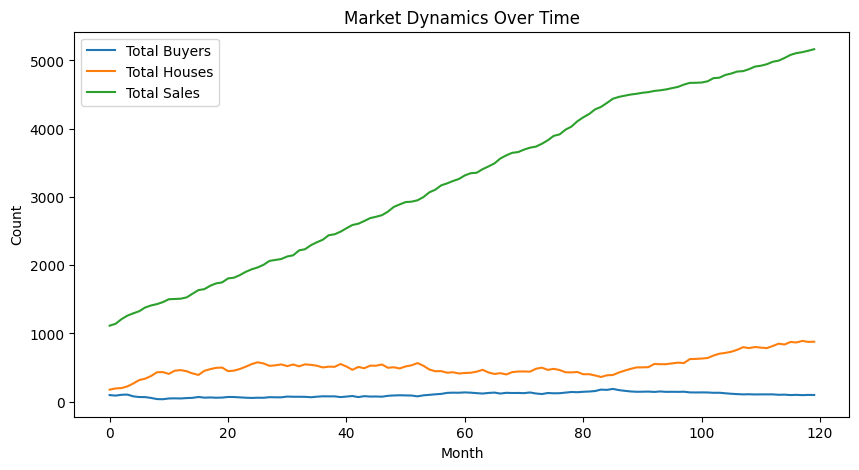

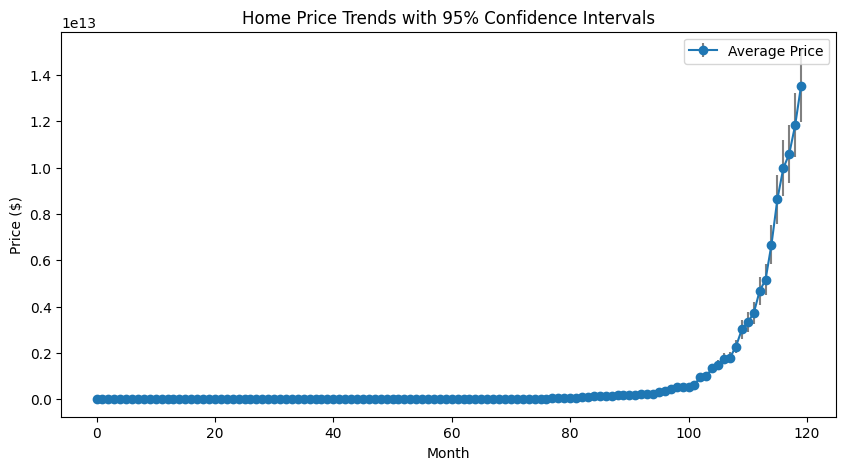

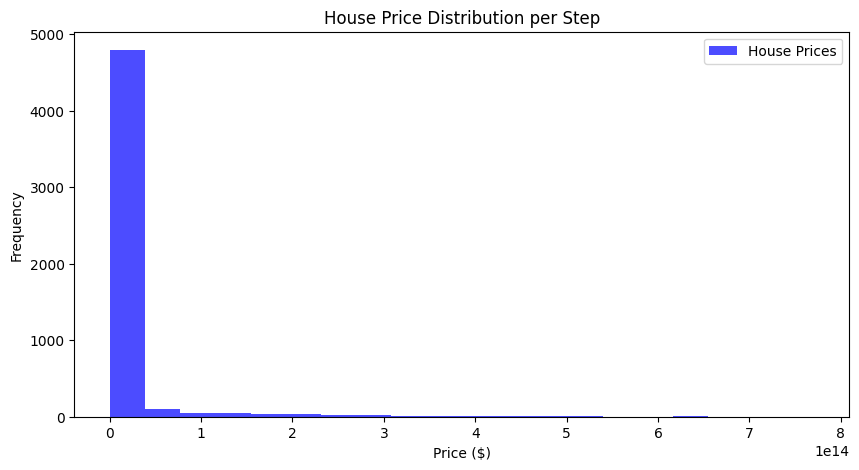

In [8]:
market.visualize()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


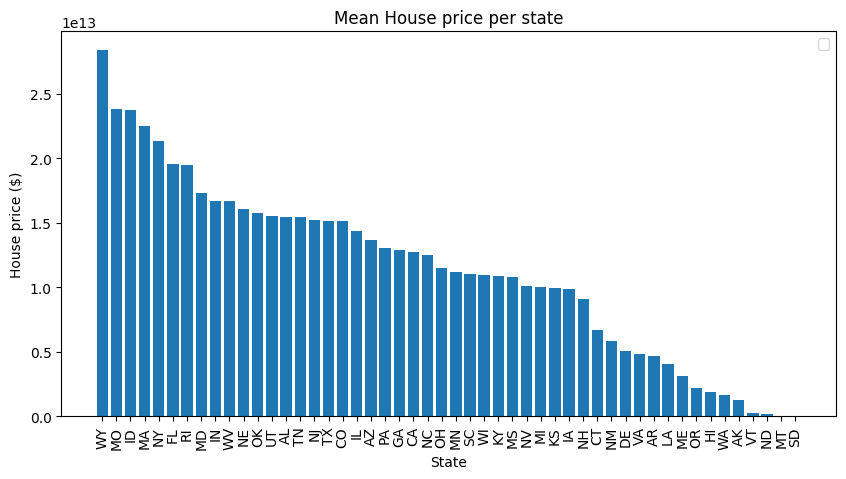

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


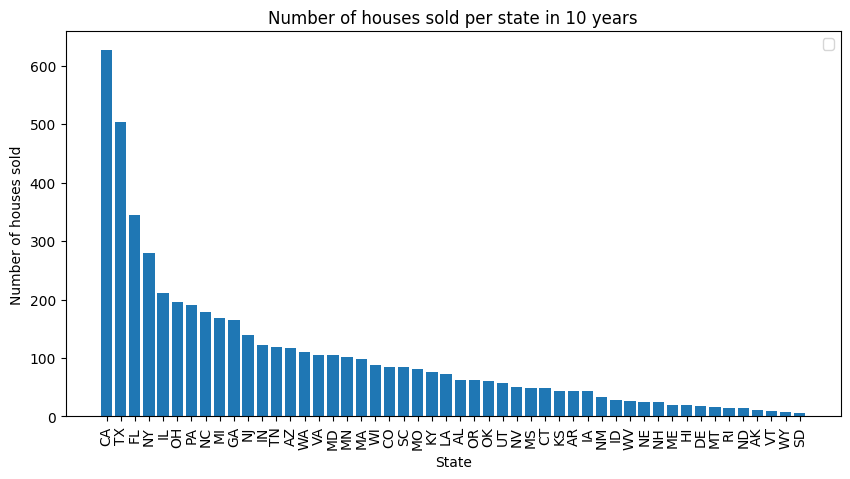

In [9]:
market.visualize_states()

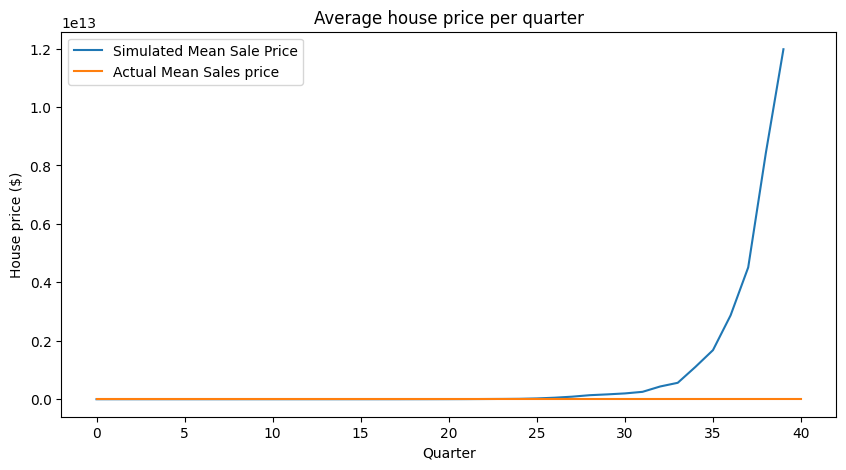

In [10]:
market.verify_visual()

In [11]:
# interest rate lists for testing the effect of interest rates
INTEREST_RATE_1P_CONST = [1 for _ in range(120)]
INTEREST_RATE_2P_CONST = [2 for _ in range(120)]
INTEREST_RATE_3P_CONST = [3 for _ in range(120)]
INTEREST_RATE_4P_CONST = [4 for _ in range(120)]
INTEREST_RATE_5P_CONST = [5 for _ in range(120)]

In [12]:
# inflation lists for testing the effect of inflation
INFLATION_1P_CONST = [1 for _ in range(120)]
INFLATION_2P_CONST = [2 for _ in range(120)]
INFLATION_3P_CONST = [3 for _ in range(120)]
INFLATION_4P_CONST = [4 for _ in range(120)]
INFLATION_5P_CONST = [5 for _ in range(120)]

51 68500
27 42100
63 68500
44 68500
63 42100
40 50600
76 37048.0
71 37048.0
31 42100
74 35420.0
57 42100
31 68500
31 42100
29 42100
40 42100
29 68500
80 50690.0
62 42100
29 42100
72 36206.0
35 42100
60 42100
50 42100
68 37048.0
43 42100
23 42100
41 50600
29 42100
35 68500
42 68500
54 42100
Buyer aged 54 has died.
34 68500
63 42100
28 68500
59 42100
56 42100
71 38732.0
63 42100
52 68500
46 42100
53 68500
25 68500
22 68500
65 43840.0
50 42100
49 42100
45 42100
55 42100
71 37890.0
21 68500
27 68500
77 39574.0
58 42100
38 68500
28 50600
45 68500
77 37048.0
72 37048.0
44 42100
51 42100
79 47950.00000000001
Buyer aged 79 has died.
70 47950.00000000001
35 68500
42 68500
53 68500
24 68500
68 36206.0
41 50600
74 53430.0
30 68500
76 50690.0
46 68500
75 52060.0
71 35364.0
22 42100
22 68500
65 56170.00000000001
20 42100
66 52060.0
79 49320.0
50 68500
37 42100
46 42100
30 42100
40 42100
62 42100
25 68500
35 68500
58 42100
25 42100
38 42100
73 37444.0
64 68500
29 68500
67 52060.0
23 42100
36 50600
4

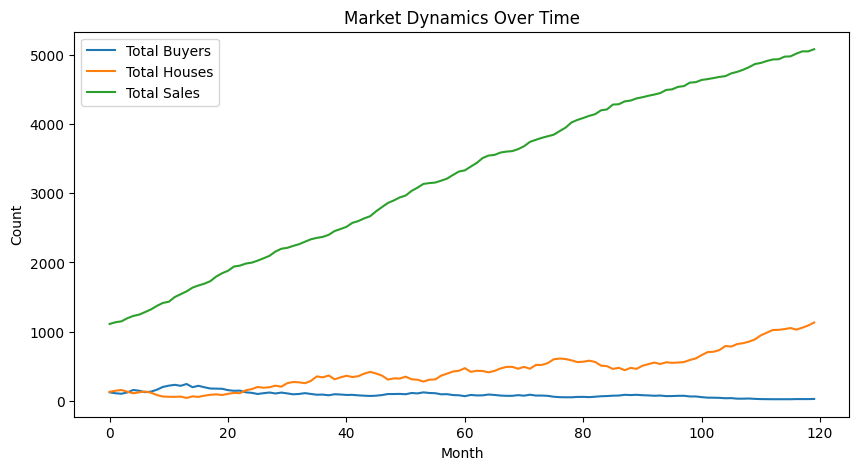

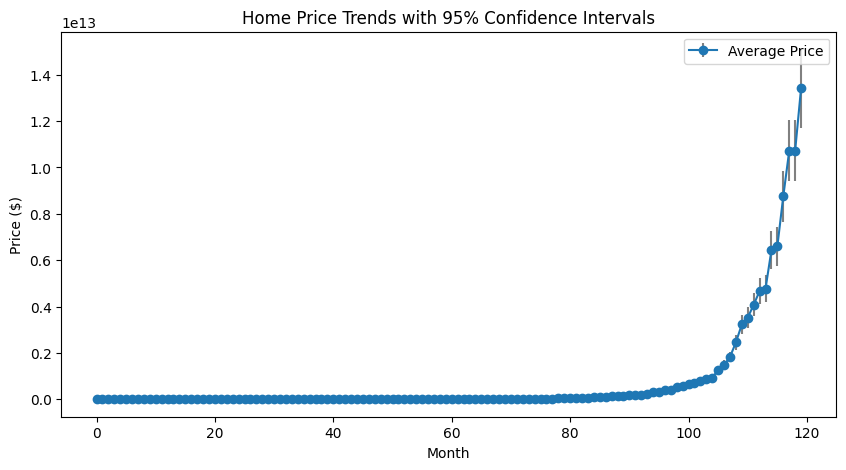

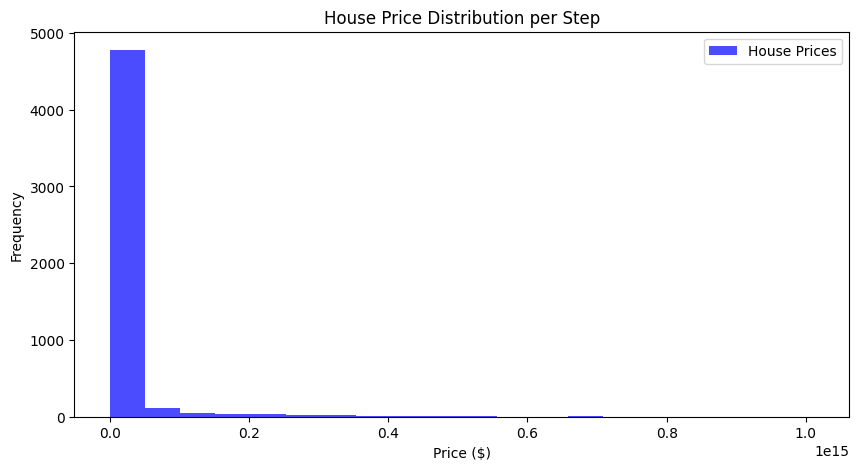

In [13]:
market_int1 = Market(num_buyers=NUM_BUYERS, num_houses=NUM_HOUSES)
for i in range(120):
    market_int1.step(INFLATION[i], INTEREST_RATE_1P_CONST[i])
market_int2 = Market(num_buyers=NUM_BUYERS, num_houses=NUM_HOUSES)
for i in range(120):
    market_int2.step(INFLATION[i], INTEREST_RATE_2P_CONST[i])
market_int3 = Market(num_buyers=NUM_BUYERS, num_houses=NUM_HOUSES)
for i in range(120):
    market_int3.step(INFLATION[i], INTEREST_RATE_3P_CONST[i])
market_int4 = Market(num_buyers=NUM_BUYERS, num_houses=NUM_HOUSES)
for i in range(120):
    market_int4.step(INFLATION[i], INTEREST_RATE_4P_CONST[i])
market_int5 = Market(num_buyers=NUM_BUYERS, num_houses=NUM_HOUSES)
for i in range(120):
    market_int5.step(INFLATION[i], INTEREST_RATE_5P_CONST[i])
market_int1.visualize()

In [14]:
market_inf1 = Market(num_buyers=NUM_BUYERS, num_houses=NUM_HOUSES)
for i in range(120):
    market_inf1.step(INFLATION_1P_CONST[i], INTEREST_RATE[i])
market_inf2 = Market(num_buyers=NUM_BUYERS, num_houses=NUM_HOUSES)
for i in range(120):
    market_inf2.step(INFLATION_2P_CONST[i], INTEREST_RATE[i])
# market_inf3 = Market(num_buyers=NUM_BUYERS, num_houses=NUM_HOUSES)
# for i in range(120):
#     market_inf3.step(INFLATION_3P_CONST[i], INTEREST_RATE[i])
# market_inf4 = Market(num_buyers=NUM_BUYERS, num_houses=NUM_HOUSES)
# for i in range(120):
#     market_inf4.step(INFLATION_4P_CONST[i], INTEREST_RATE[i])
# market_intf = Market(num_buyers=NUM_BUYERS, num_houses=NUM_HOUSES)
# for i in range(120):
#     market_inf5.step(INFLATION_5P_CONST[i], INTEREST_RATE[i])
# market_intf.visualize()

72 37890.0
60 42100
76 39574.0
33 68500
39 50600
63 68500
62 42100
46 68500
78 43840.0
37 50600
28 42100
60 68500
57 68500
35 68500
29 42100
78 50690.0
22 42100
30 42100
61 42100
19 42100
24 42100
40 42100
59 68500
40 50600
74 53430.0
58 50600
36 50600
22 42100
24 50600
22 42100
68 50690.0
64 68500
37 68500
31 42100
39 68500
45 42100
25 42100
22 68500
59 50600
80 35364.0
20 68500
27 42100
29 50600
60 42100
39 42100
36 42100
58 42100
36 68500
72 38732.0
74 38456.0
28 42100
24 68500
75 50690.0
35 42100
25 42100
47 42100
42 68500
31 42100
80 50690.0
40 50600
49 42100
50 68500
77 37890.0
68 42470.0
78 45210.0
Buyer aged 78 has died.
31 68500
29 68500
72 52060.0
61 50600
66 50690.0
25 50600
28 42100
37 42100
45 42100
20 42100
24 42100
61 68500
33 42100
76 39574.0
48 68500
60 42100
80 37048.0
68 38732.0
49 68500
43 68500
49 42100
24 68500
39 42100
43 50600
53 50600
77 46580.0
23 68500
70 45210.0
52 50600
61 42100
47 50600
26 50600
57 50600
22 42100
60 42100
46 68500
60 42100
25 42100
41 4210

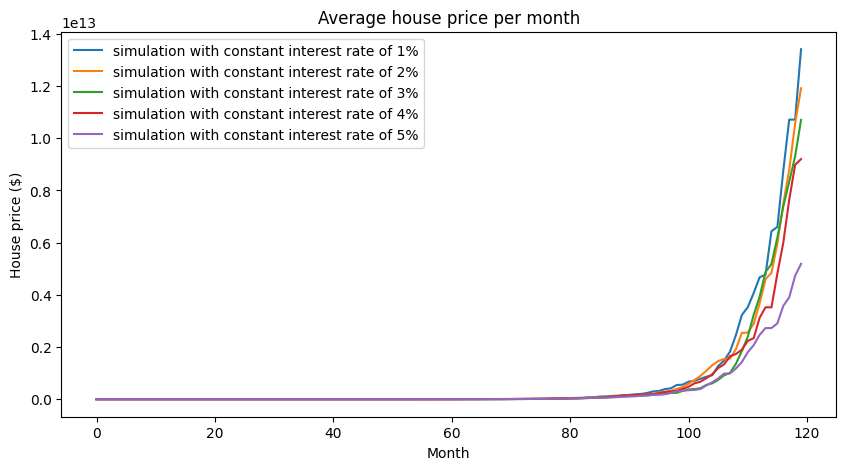

In [15]:
plt.figure(figsize=(10, 5))
result_list = [market_int1.return_results()[3], market_int2.return_results()[3], market_int3.return_results()[3], market_int4.return_results()[3], market_int5.return_results()[3]]
for i in range(5):
    plt.plot(result_list[i], label = f"simulation with constant interest rate of {i + 1}%")
plt.title("Average house price per month")
plt.xlabel("Month")
plt.ylabel("House price ($)")
plt.legend()
plt.show()